## Data Prepocessing 

Import Library

In [1]:
# library for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from sklearn.model_selection import train_test_split 


import os 

In [2]:
dataset_dir = './dataset/'

In [3]:
# load dataset 
destination = pd.read_csv( os.path.join(dataset_dir, 'tourism_with_id.csv') )
rating = pd.read_csv(os.path.join(dataset_dir, 'tourism_rating.csv'))
user = pd.read_csv(os.path.join(dataset_dir, 'user.csv'))

In [4]:
print(f'number of tourist destination = {len(destination.Place_Id.unique())}')
print(f'number of user = {len(user.User_Id.unique())}')


number of tourist destination = 437
number of user = 300


In [5]:
destination = destination.drop(['Coordinate', 'Time_Minutes'], axis=1)
destination.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.17539,106.8272
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,5000,4.6,-6.13764,106.8171


## Collaborative Filtering
Collaborative Filtering uses algorithms to filter data from user reviews to make personalized recommendations for users with similar preferences

### Split data for Training and Testing

In [6]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [7]:
train, test = train_test_split(rating, test_size = 0.2)

In [8]:
print(train.shape)
print(test.shape)

(8000, 3)
(2000, 3)


In [9]:
number_user = len(rating['User_Id'].unique())
number_destination = len(rating['Place_Id'].unique())

print(f'number of user = {number_user}')
print(f'number of place name = {number_destination}')

number of user = 300
number of place name = 437


In [10]:
# build recommendation system using emmbedding layers 
EMBEDDING_DIM = 50

# input layers 
place_input = Input(shape=[1])
user_input = Input(shape=[1])

# embedding layers
place_embedding = Embedding(number_destination+1 , EMBEDDING_DIM)(place_input)
user_embedding = Embedding(number_user+1 , EMBEDDING_DIM)(user_input)

# flatte the embedddings
place_flat = Flatten()(place_embedding)
user_flat = Flatten()(user_embedding)

# add dense layers
dense1 = Dense(64, activation='relu')(place_flat)
dense2 = Dense(64, activation='relu')(user_flat)

# output layer
output = Dot(1)([dense1, dense2])

# the model
model = Model([place_input, user_input], [output])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        21900       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        15050       ['input_2[0][0]']                
                                                                                              

In [12]:
model.compile(loss = 'mean_squared_error', 
              optimizer = Adam(learning_rate = 0.0005)
              )

In [13]:
history = model.fit(x= [train.Place_Id, train.User_Id], 
                    y= train.Place_Ratings, 
                    validation_data = ([test.Place_Id, test.User_Id], test.Place_Ratings), 
                    batch_size =32 , 
                    epochs =30)

Epoch 1/30
250/250 [==============================] - 2s 3ms/step - loss: 6.3624 - val_loss: 1.9652
Epoch 2/30
250/250 [==============================] - 1s 2ms/step - loss: 1.9789 - val_loss: 1.9602
Epoch 3/30
250/250 [==============================] - 1s 2ms/step - loss: 1.8959 - val_loss: 1.9547
Epoch 4/30
250/250 [==============================] - 1s 2ms/step - loss: 1.8678 - val_loss: 1.9530
Epoch 5/30
250/250 [==============================] - 1s 2ms/step - loss: 1.8478 - val_loss: 1.9515
Epoch 6/30
250/250 [==============================] - 1s 2ms/step - loss: 1.8387 - val_loss: 1.9574
Epoch 7/30
250/250 [==============================] - 1s 2ms/step - loss: 1.8206 - val_loss: 1.9541
Epoch 8/30
250/250 [==============================] - 1s 2ms/step - loss: 1.8109 - val_loss: 1.9481
Epoch 9/30
250/250 [==============================] - 0s 2ms/step - loss: 1.7977 - val_loss: 1.9503
Epoch 10/30
250/250 [==============================] - 1s 2ms/step - loss: 1.7868 - val_loss: 1.9406

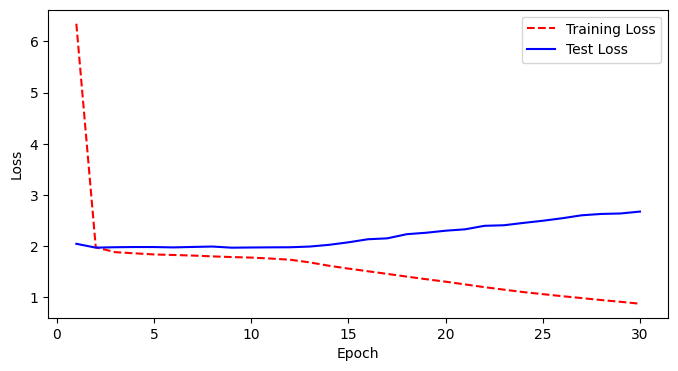

In [28]:
# plotting validation curves 
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# create count of the number of epochs 
epoch_count = range(1, len(training_loss) + 1)

# visualize loss history 
plt.figure(figsize= (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [29]:
# evaluate the model on test data
test_accuracy = model.evaluate([test.Place_Id, test.User_Id], test.Place_Ratings)
test_accuracy

63/63 [==============================] - 0s 2ms/step - loss: 2.6771


2.677090883255005

In [30]:
# evaluating RMSE
score= model.evaluate([test.Place_Id, test.User_Id], test.Place_Ratings)
print()

print(f'RMSE = ', format(np.sqrt(score)))

63/63 [==============================] - 0s 2ms/step - loss: 2.6771

RMSE =  1.6361818001845043


because the RMSE value is small enough, the model we make is good enough to be used as a recommendation system based on collaborative filtering

In [ ]:
model.save('model.h5')

In [40]:
from inspect import FullArgSpec
# recommendation system function using collaborative filtering
def collaborative_rec(User_Id, destination ,model, np_val):
  destination = destination.copy()
  user_ids = np.array([User_Id] * len(destination))
  results = model([destination.Place_Id.values, user_ids]).numpy().reshape(-1)

  destination['predicted_rating'] = pd.Series(results)
  destination = destination.sort_values('predicted_rating', ascending = False)

  dataFinal = destination[:np_val]
  
  return dataFinal['Place_Name'].tolist()

In [41]:
collaborative_rec(207, destination, model, 5)

['Bunker Kaliadem Merapi',
 'Kampung Cina',
 'Puncak Kebun Buah Mangunan',
 'Museum Bahari Jakarta',
 'La Kana Chapel']